In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint,EarlyStopping
import datetime
from keras import regularizers
import matplotlib.pyplot as plt
#from keras.utils.vis_utils import plot_model

In [2]:
!gdown 1NFuR4csQb0ZuNBIlI7ZaVgNDktBM57wV

Downloading...
From: https://drive.google.com/uc?id=1NFuR4csQb0ZuNBIlI7ZaVgNDktBM57wV
To: /content/archive.zip
100% 63.3M/63.3M [00:01<00:00, 32.0MB/s]


In [3]:
!rm -r FER

rm: cannot remove 'FER': No such file or directory


In [4]:
!unzip archive.zip -d FER

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: FER/train/sad/Training_65242339.jpg  
  inflating: FER/train/sad/Training_65267116.jpg  
  inflating: FER/train/sad/Training_65275626.jpg  
  inflating: FER/train/sad/Training_6529266.jpg  
  inflating: FER/train/sad/Training_65329617.jpg  
  inflating: FER/train/sad/Training_65338712.jpg  
  inflating: FER/train/sad/Training_65338797.jpg  
  inflating: FER/train/sad/Training_65387162.jpg  
  inflating: FER/train/sad/Training_65404494.jpg  
  inflating: FER/train/sad/Training_65426218.jpg  
  inflating: FER/train/sad/Training_65430136.jpg  
  inflating: FER/train/sad/Training_65437377.jpg  
  inflating: FER/train/sad/Training_6545735.jpg  
  inflating: FER/train/sad/Training_65463385.jpg  
  inflating: FER/train/sad/Training_65473985.jpg  
  inflating: FER/train/sad/Training_65502829.jpg  
  inflating: FER/train/sad/Training_65505359.jpg  
  inflating: FER/train/sad/Training_65508578.jpg  
  inflating: FER/train/

In [5]:
!rm -r FER/test/fear
!rm -r FER/test/disgust
!rm -r FER/train/disgust
!rm -r FER/train/fear
!rm -r FER/test/neutral
!rm -r FER/train/neutral

In [6]:
train = 'FER/train/'
test = 'FER/test/'

In [7]:
h,w = 48, 48
classes = 4

In [8]:
num_type_train = {}
for type in os.listdir(train):
  path = train + type
  num_type_train[type] = len(os.listdir(path))
train_num = pd.DataFrame(num_type_train, index=[train])

num_type_test = {}
for type in os.listdir(test):
  path = test + type
  num_type_test[type] = len(os.listdir(path))
test_num = pd.DataFrame(num_type_test, index=[test])

print(train_num)
print(test_num)

            surprise  happy   sad  angry
FER/train/      3171   7215  4830   3995
           surprise  happy   sad  angry
FER/test/       831   1774  1247    958


In [9]:
train_data_gen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)
X_train = train_data_gen.flow_from_directory(train, target_size = (48,48), shuffle = True, color_mode = 'grayscale', class_mode = 'categorical', subset = 'training')
validation_data_gen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)
X_validation = validation_data_gen.flow_from_directory(train, target_size = (48,48), shuffle = True, color_mode = 'grayscale', class_mode = 'categorical', subset = 'validation')

test_data_gen = ImageDataGenerator(rescale = 1./255)
X_test = test_data_gen.flow_from_directory(test, target_size = (48,48), shuffle = True, color_mode = 'grayscale', class_mode = 'categorical')

Found 15369 images belonging to 4 classes.
Found 3842 images belonging to 4 classes.
Found 4810 images belonging to 4 classes.


In [10]:
X_train.class_indices

{'angry': 0, 'happy': 1, 'sad': 2, 'surprise': 3}

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

def get_model(input_shape: tuple = (48, 48, 1), num_classes: int = 4):
  #--------------------DATA AUGMENTATION----------------------
  data_augmentation = Sequential([
    layers.RandomRotation(factor=1/12, fill_mode='nearest', input_shape=input_shape),
    #layers.RandomFlip("horizontal"),
    layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1,0.1), fill_mode='nearest'),
    layers.RandomBrightness(factor=0.1, value_range=(0, 1)),
  ]) #Modificamos las fotos para generar otras a partir de girar, aumentar o rotar imagenes del set


  #----------------MODEL-----------------------
  model = Sequential([
    data_augmentation,
    # Bloque extractor de características
    layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(),
    # datos -> [H//2, W //2, 16]
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    # datos -> [H//4, W //4, 32]
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    # datos -> [H//8, W //8, 64]
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    # datos -> [H//16, W //16, 128]
    layers.Dropout(0.2), # DROPOUT
    layers.Flatten(),
    # tamaño original es (48, 48, 1)
    # (48//16, 48//16, 128) == (3, 3, 128)
    # flatten sobre esta matriz tenemos un vector de 3x3x128=1152 elementos
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
  ])
  return model
  #1024,2048

In [44]:
model = get_model()
print(model.summary())

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_14 (Sequential)  (None, 48, 48, 1)         0         
                                                                 
 conv2d_27 (Conv2D)          (None, 48, 48, 16)        160       
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 24, 24, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 12, 12, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 12, 12, 64)      

In [45]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0003), metrics=['accuracy'])

In [46]:
epochs_num = 20
batch_size = 200
steps_per_epoch = 480
validation_steps = X_validation.n // X_validation.batch_size
#callbacks = [checkpointer]
print('-------Entrenando-------')
train_history = model.fit(x = X_train, validation_data = X_validation, epochs = epochs_num, steps_per_epoch = steps_per_epoch, validation_split=0.2)
#train_history = model.fit(train_data, epochs=epochs, batch_size=batch_size, validation_split=0.2)
print('---------Probando-------')
test_history = model.evaluate(X_test, batch_size = X_test.batch_size, steps = X_test.n // X_test.batch_size)

#model_1.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])
#validation_steps = validation_steps



-------Entrenando-------
Epoch 1/20
480/480 [==============================] - 12s 20ms/step - loss: 1.2951 - accuracy: 0.4011 - val_loss: 1.1753 - val_accuracy: 0.4792
Epoch 2/20
480/480 [==============================] - 9s 19ms/step - loss: 1.1570 - accuracy: 0.4952 - val_loss: 1.0529 - val_accuracy: 0.5476
Epoch 3/20
480/480 [==============================] - 11s 22ms/step - loss: 1.0658 - accuracy: 0.5459 - val_loss: 1.0396 - val_accuracy: 0.5398
Epoch 4/20
480/480 [==============================] - 9s 19ms/step - loss: 1.0116 - accuracy: 0.5691 - val_loss: 0.9894 - val_accuracy: 0.5721
Epoch 5/20
480/480 [==============================] - 9s 18ms/step - loss: 0.9749 - accuracy: 0.5866 - val_loss: 0.9062 - val_accuracy: 0.6124
Epoch 6/20
480/480 [==============================] - 9s 19ms/step - loss: 0.9407 - accuracy: 0.6017 - val_loss: 0.9399 - val_accuracy: 0.6093
Epoch 7/20
480/480 [==============================] - 9s 20ms/step - loss: 0.9183 - accuracy: 0.6160 - val_loss: 0.

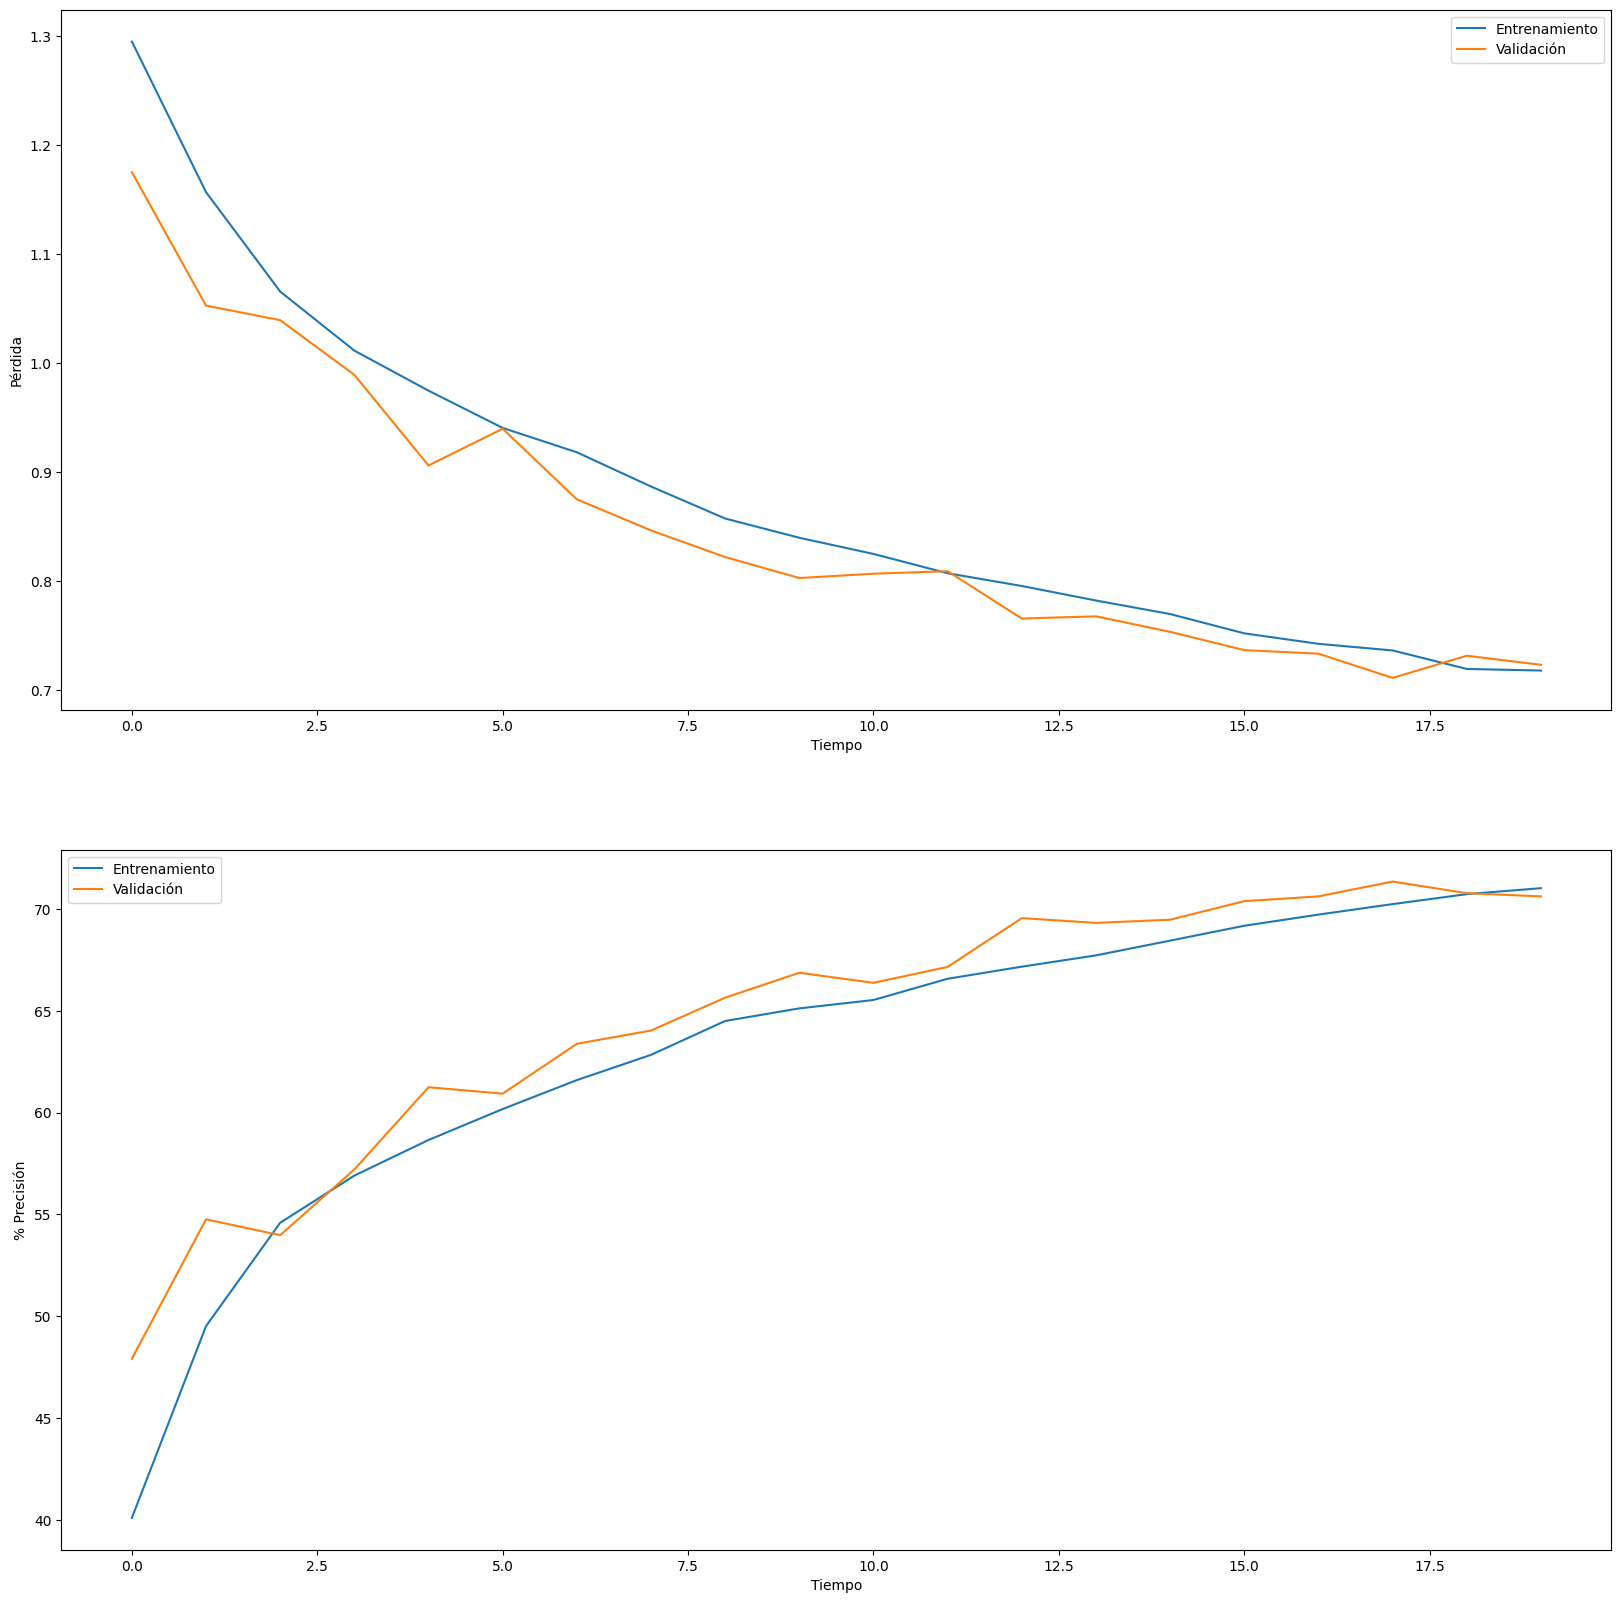

In [47]:
# Gráfica de perdida y precisión
import matplotlib.pyplot as plt

def plot_metrics():
    fig, axs = plt.subplots(2, 1, figsize=(20, 20))
    for i in range(2):
        if i == 0:
            axs[i].plot(train_history.history['loss'])
            axs[i].plot(train_history.history['val_loss'])
            #axs[i].plot(np.full(shape=epochs_num, fill_value=test_history['loss']))
            axs[i].set_ylabel('Pérdida')
        else:
            axs[i].plot(np.array(train_history.history['accuracy']) * 100) # *100 porcentaje
            axs[i].plot(np.array(train_history.history['val_accuracy']) * 100)
            #axs[i].plot(np.full(shape=epochs_num, fill_value=test_history['accuracy'] * 100))
            axs[i].set_ylabel('% Precisión')
        axs[i].set_xlabel('Tiempo')
        axs[i].legend(['Entrenamiento', 'Validación', 'Test'])
    plt.show()

plot_metrics()

In [18]:
!mkdir models

In [19]:
model.save('models/prueba2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
